In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from pathlib import Path


ATTR_SPEC_PATH = 'data/attr.txt'


def parse_attr_spec_line(line: str) -> (str, str):
    key, desc = line.split(':', maxsplit=1)
    _, name = key.split('--')
    return name.strip(), desc.strip()


def read_attr_spec(path=ATTR_SPEC_PATH) -> OrderedDict:
    path = Path(path)
    with path.open() as file:
        attr_spec = OrderedDict(parse_attr_spec_line(line)
                                for line in file
                                if '--' in line)
    return attr_spec


def discretize(data: pd.Series) -> pd.Series:
    std = data.std()
    mean = data.mean()
    bins = np.array([-np.inf, -1.5 * std, -0.5 * std, 0.5 * std, 1.5 * std, np.inf]) + mean
    return pd.cut(data, bins, labels=[-2, -1, 0, 1, 2])

In [2]:
# Load all data
original_data = pd.read_csv('data/communities.data', header=None, index_col=None)
attr_spec = read_attr_spec()
original_data.columns = list(attr_spec.keys())

In [3]:
# Filter interesting states
STATES = {
    'Indiana': 18,
    'Ohio': 39,
    'West Virginia': 54,
    'Virginia': 51,
    'Kentucky': 21,
    'Tennessee': 47
}
data = original_data[original_data['state'].isin(STATES.values())]

In [4]:
means = data.mean()
stds = data.std()
selected_attrs = [
    'LandArea',
    'numbUrban',
    'medIncome',
    'agePct12t21',
    'NumUnderPov',
    'PctUnemployed',
    'ViolentCrimesPerPop'
]
ex_data = data[selected_attrs]

In [5]:
# uncomment to discretize the data
# ex_data = ex_data.apply(discretize)

In [6]:
X = ex_data.values
np.random.shuffle(X)
TEST_SET_SIZE = 50

# Train set
X_train = X[-TEST_SET_SIZE:, :-1]
y_train = X[-TEST_SET_SIZE:, -1]  # extract the labels

# Test set
X_test = X[:-TEST_SET_SIZE, :-1]
y_test = X[:-TEST_SET_SIZE, -1]  # extract the labels

In [7]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
D = 6  # number of features

X = tf.placeholder(tf.float32, [None, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=1./6)
b = ed.models.Normal(loc=tf.zeros(1), scale=0.5)
ys = ed.models.Uniform(0.0, 0.5)
y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=ys)

In [8]:
qw = ed.models.PointMass(tf.get_variable("qw", [D]))
qb = ed.models.PointMass(tf.get_variable("qb", [1]))
qys = ed.models.PointMass(tf.nn.softplus(tf.get_variable("qys", [])))

In [9]:
inference = ed.MAP({w: qw, b: qb, ys: qys}, data={X: X_train, y: y_train})
inference.run(n_iter=1000)
y_post = ed.copy(y, {w: qw, b: qb, ys: qys})

/home/pkubik/anaconda3/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 0s | Loss: -16.650


In [10]:
print("Mean squared error on train data:")
print(ed.evaluate('mean_squared_error', data={X: X_train, y_post: y_train}))

print("Log loss on train data:")
print(ed.evaluate('log_loss', data={X: X_train, y_post: y_train}))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Log loss on test data:")
print(ed.evaluate('log_loss', data={X: X_test, y_post: y_test}))

Mean squared error on train data:
0.03281951
Log loss on train data:


/home/pkubik/anaconda3/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


0.74419683
Mean squared error on test data:
0.024710815
Log loss on test data:
0.74658525


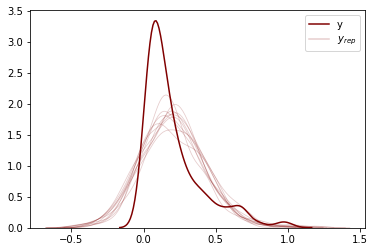

In [11]:
ed.ppc_density_plot(y_test, y_post.sample([10]).eval({X: X_test}))
plt.show()

In [12]:
print("Estimated output std: {}".format(qys.eval()))
print("Estimated w: {}".format(qw.eval()))
print("Estimated b: {}".format(qb.eval()))

Estimated output std: 0.17994004487991333
Estimated w: [ 0.15209717  0.1924208  -0.1629371   0.04425019  0.22336283  0.2738569 ]
Estimated b: [0.10004576]


In [13]:
print("Deterministic MSE: {}".format(np.mean((y_post.loc.eval({X: X_test}) - y_test)**2)))

Deterministic MSE: 0.024899599790590095
